In [2]:
import uproot
import numpy as np
import ROOT
import itertools
from array import array
ROOT.gROOT.SetStyle('ATLAS')
import time
import os

def draw_note(x, y, text, size=12, font=63):
    l = ROOT.TLatex()
    l.SetNDC()
    l.SetTextColor(1)
    l.DrawLatex(x, y, text)

def atlas_label(x, y, text=None, color=1):
    draw_note(x, y, r"#bf{#it{ATLAS}} " + text)

FONT_SIZE = 30

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/LRT/lrtanalysis/run/maximalNN/fake_comparison_track_eta.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/LRT/lrtanalysis/run/maximalNN/fake_comparison_track_absz0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/LRT/lrtanalysis/run/maximalNN/fake_comparison_track_absd0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TH1D::Sumw2>: Sum of squares of weights struc

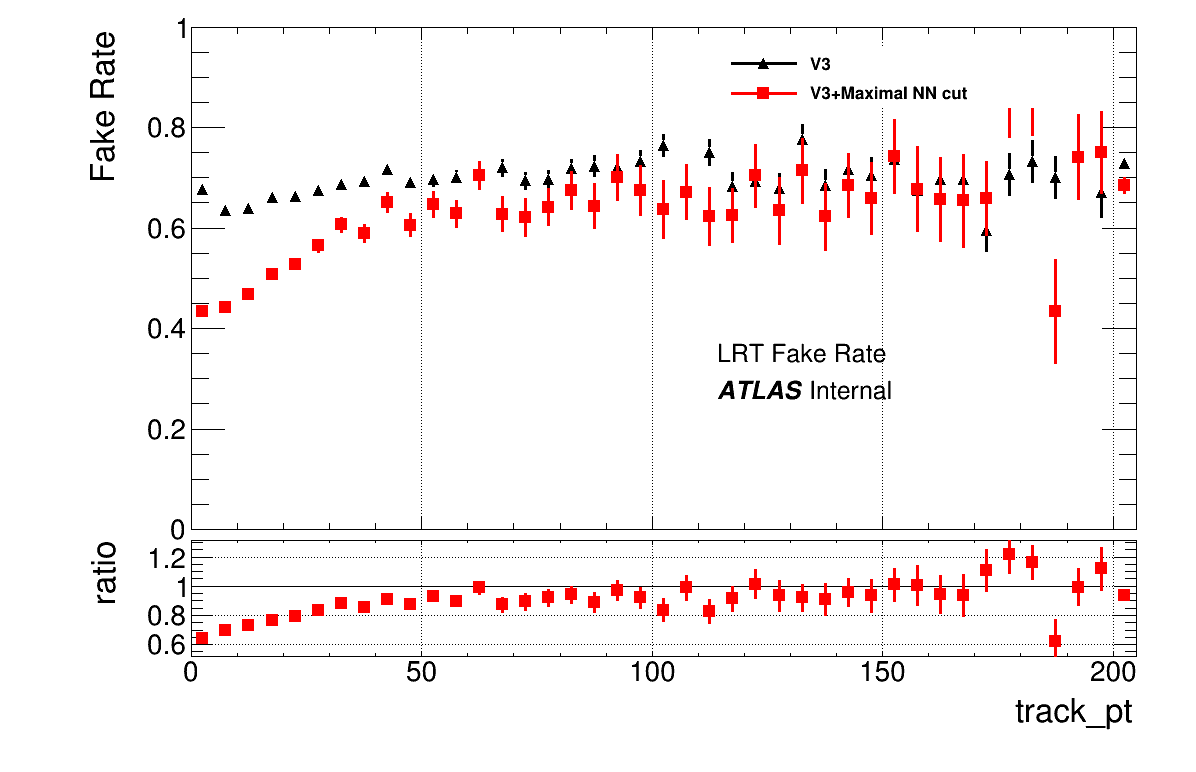

In [120]:
variables = {
    'track_eta' : (-3,3),
    'track_absz0' : (0,10000),
    'track_absd0' : (0,300),
    'track_r' : (0,1000),
    'track_pt' : (0,1000000),
}
output_dir = "/home/newhouse/public/Analysis/LRT/lrtanalysis/run/VH4b/"
os.makedirs(output_dir, exist_ok=True)

for var, bounds in variables.items():
    # bins = [2, 2.5, 3, 4, 6, 8, 10]
    hist_markers = itertools.cycle([22,21,33,29,30,31,32,34,35])
    hist_colors = itertools.cycle([ROOT.kBlack, ROOT.kRed, ROOT.kAzure+6, ROOT.kViolet+8, ROOT.kGreen+1, ROOT.kOrange -3])
    tree_name = 'Efficiency'
    tree1 = 'v3'
    tree2 = 'v3_mod'
    # Open file
    tfiles = {tree1: ROOT.TFile('/home/newhouse/public/Analysis/LRT/lrtanalysis/run/Fake_filesV3.root'),
              tree2: ROOT.TFile('/home/newhouse/public/Analysis/LRT/lrtanalysis/run/Fake_filesV3maximalNN.root')}

    # Load tree from file
    ttree = {tree1: tfiles[tree1].Get(tree_name),
             tree2:  tfiles[tree2].Get(tree_name)}
    # ttree['v3'].ls()

    hist =  {tree1 : ttree[tree1].Get(var),
            tree2 : ttree[tree2].Get(var),}

    # Upper plot will be in pad1
    c = None
    scale = 1.0
    c = ROOT.TCanvas("c", "", int(1200*scale), int(800*scale))
    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.02);  # Upper and lower plot are not joined
    pad1.SetGridx();          # Vertical grid
    pad1.Draw();              # Draw the upper pad: pad1
    pad1.cd();                # pad1 becomes the current pad
    
    # Set draw properties
    for key, h in hist.items():
        # Histogram properties
        h.SetMarkerSize(1.5*scale)
        h.SetLineWidth(int(3*scale))
        hcolor = next(hist_colors)
        h.SetLineColor(hcolor)
        h.SetMarkerColor(hcolor)
        h.SetMarkerStyle(next(hist_markers))
        # X axis
        h.GetXaxis().SetRangeUser(bounds[0], bounds[1]);
        h.GetXaxis().SetLabelSize(0);
        h.GetXaxis().SetTitle(var)
        h.GetYaxis().SetTitle("Fake Rate")
        # Y axis
        h.GetYaxis().SetMaxDigits(6);
        h.GetYaxis().SetTitleOffset(1.0)
        h.GetYaxis().SetRangeUser(0,1);
        h.GetYaxis().SetLabelFont(43);  # Absolute font size in pixel (precision 3)
        h.GetYaxis().SetLabelSize(FONT_SIZE);   
        h.GetYaxis().SetTitleFont(43)  # Absolute font size in pixel (precision 3)
        h.GetYaxis().SetTitleSize(FONT_SIZE*1.2)
        
    hist[tree1].Draw()
    hist[tree2].Draw("SAME")
    
    # format legend
    x = 0.6
    y = 0.4
    leg = ROOT.TLegend(x, 0.8, 0.91, 0.91)
    leg.SetTextSize(0.035)
    leg.SetBorderSize(0)
    leg.SetFillColor(ROOT.kWhite)
    leg.SetShadowColor(ROOT.kWhite)
    leg.AddEntry(hist[tree1], "V3", "lp")
    leg.AddEntry(hist[tree2], "V3+Maximal NN cut", "lp")
    dy = .07
    draw_note(x, y-dy, 'LRT Fake Rate')
    atlas_label(x,y-2*dy, 'Internal')
    leg.Draw()


    # lower plot will be in pad 2
    c.cd();          # Go back to the main canvas before defining pad2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.4)
    pad2.SetGridx() # vertical grid
    pad2.SetGridy() # horizontal grid
    pad2.Draw()
    pad2.cd() # pad2 becomes the current pad
    
    # Define the ratio plot
    h3 = hist[tree2].Clone("h3");
    h3.SetLineColor(hcolor);
    h3.SetMinimum(0.5);  # Define Y ..
    h3.SetMaximum(1.5); # .. range
    h3.Sumw2();
#     h3.SetStats(0);      # No statistics on lower plot
    h3.Divide(hist[tree1]);
    h3.SetMarkerStyle(21);
    max_bin_content = h3.GetBinContent(h3.GetMaximumBin())
    min_bin_content = h3.GetBinContent(h3.GetMinimumBin())
    h3.SetMaximum(1.4 if max_bin_content > 1.3 else max_bin_content + .1);
    h3.SetMinimum(min_bin_content - .1);
    hline = ROOT.TLine(h3.GetBinCenter(h3.FindFirstBinAbove()), 1, h3.GetBinCenter(h3.FindLastBinAbove()), 1)
#     h3.Draw("ep ");       # Draw the ratio plot 
    pad2.SetFillStyle(0)
    h3.Draw("ep") # Draw the ratio plot 
    hline.Draw("Same")
    h3.Draw("ep Same") # Draw the ratio plot 

    # Y axis ratio plot settings
    h3.GetYaxis().SetTitle("ratio")
    h3.GetYaxis().SetNdivisions(505)
    h3.GetYaxis().SetTitleSize(FONT_SIZE*1.2)
    h3.GetYaxis().SetTitleFont(43)
    h3.GetYaxis().SetTitleOffset(1.0)
    h3.GetYaxis().SetLabelFont(43)  # Absolute font size in pixel (precision 3)
    h3.GetYaxis().SetLabelSize(FONT_SIZE)
    # X axis ratio plot settings
    h3.GetXaxis().SetTitleSize(FONT_SIZE*1.2);
    h3.GetXaxis().SetTitleFont(43);
    h3.GetXaxis().SetTitleOffset(4.);
    h3.GetXaxis().SetLabelFont(43);  # Absolute font size in pixel (precision 3)
    h3.GetXaxis().SetLabelSize(FONT_SIZE);  
    
    
    c.Draw()
    c.SaveAs(f'{output_dir}fake_comparison_{var}.png')

In [110]:
h3.GetBinCenter(h3.GetMaximumBin())

177.5

Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/LRT/lrtanalysis/run/GeomCut/techeff_comparison_truth_eta.png has been created
Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/LRT/lrtanalysis/run/GeomCut/techeff_comparison_truth_absz0.png has been created
Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/LRT/lrtanalysis/run/GeomCut/techeff_comparison_truth_absd0.png has been created
Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/LRT/lrtanalysis/run/GeomCut/techeff_comparison_truth_r.png has been created
Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/LRT/lrtanalysis/run/GeomCut/techeff_comparison_truth_pt.png has been created


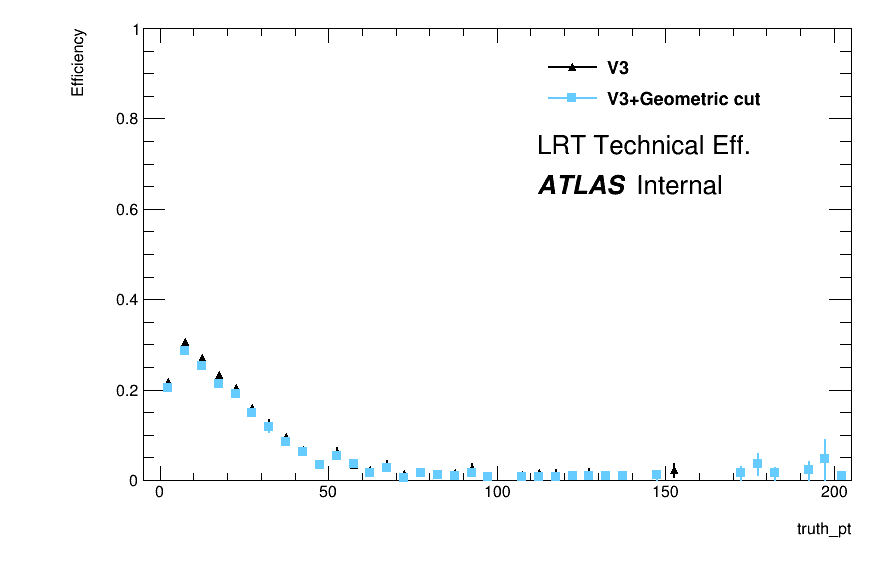

In [103]:
variables = {
    'truth_eta' : (-3,3),
    'truth_absz0' : (0,10000),
    'truth_absd0' : (0,300),
    'truth_r' : (0,1000),
    'truth_pt' : (-100, 10000),
}
output_dir = "/home/newhouse/public/Analysis/LRT/lrtanalysis/run/GeomCut/"
os.makedirs(output_dir, exist_ok=True)

for var, bounds in variables.items():
    # bins = [2, 2.5, 3, 4, 6, 8, 10]
    hist_markers = itertools.cycle([22,21,33,29,30,31,32,34,35])
    hist_colors = itertools.cycle([ROOT.kBlack ,ROOT.kAzure+6, ROOT.kRed, ROOT.kViolet+8, ROOT.kGreen+1, ROOT.kOrange -3])
    tree_name = 'Efficiency'
    tree1 = 'v3'
    tree2 = 'v3_mod'
    # Open file
    tfiles = {tree1: ROOT.TFile('/home/newhouse/public/Analysis/LRT/lrtanalysis/run/Efficiency_filesV3.root'),
              tree2: ROOT.TFile('/home/newhouse/public/Analysis/LRT/lrtanalysis/run/Efficiency_filesV3GeomCut.root')}

    # Load tree from file
    c = None
    scale = 0.75
    c = ROOT.TCanvas("c", "", int(1200*scale), int(800*scale))
    ttree = {tree1: tfiles[tree1].Get(tree_name),
             tree2:  tfiles[tree2].Get(tree_name)}
    # ttree['v3'].ls()

    hist =  {tree1 : ttree[tree1].Get(var),
            tree2 : ttree[tree2].Get(var),}



    # Set draw properties
    for key, h in hist.items():
        h.GetXaxis().SetTitle(var)
        h.GetYaxis().SetTitle("Efficiency")
        h.SetMarkerSize(1.5*scale)
        h.SetLineWidth(int(3*scale))
        h.GetXaxis().SetRangeUser(bounds[0], bounds[1]);
        h.GetYaxis().SetMaxDigits(6);
        h.GetYaxis().SetRangeUser(0,1);
        hcolor = next(hist_colors)
        h.SetLineColor(hcolor)
        h.SetMarkerColor(hcolor)
        h.SetMarkerStyle(next(hist_markers))

    
    hist[tree1].Draw()
    hist[tree2].Draw("SAME")
    
    # format legend
    x = 0.6
    y = 0.8
    leg = ROOT.TLegend(x, 0.8, 0.91, 0.91)
    leg.SetTextSize(0.035)
    leg.SetBorderSize(0)
    leg.SetFillColor(ROOT.kWhite)
    leg.SetShadowColor(ROOT.kWhite)
    leg.AddEntry(hist[tree1], "V3", "lp")
    leg.AddEntry(hist[tree2], "V3+Geometric cut", "lp")
    dy = .07
    draw_note(x, y-dy, 'LRT Technical Eff.')
    atlas_label(x,y-2*dy, 'Internal')
    

    leg.Draw()
    c.Draw()
    c.SaveAs(f'{output_dir}techeff_comparison_{var}.png')


In [22]:
tfiles = {'v7': ROOT.TFile('/home/newhouse/public/Analysis/LRT/lrtanalysis/run/plots/EfficiencyComparison_files_VH4b_V7.root'),
          'v7nn': ROOT.TFile('/home/newhouse/public/Analysis/LRT/lrtanalysis/run/output/files_VH4b_V7nn.root')}

TDirectoryFile*		TruthLinkedIsLRTIsSignalTechnical	TruthLinkedIsLRTIsSignalTechnical
 KEY: TH1D	track_absd0;1	track_absd0
 KEY: TH1D	track_absz0;1	track_absz0
 KEY: TH1D	track_chi2pernDOF;1	track_chi2pernDOF
 KEY: TH1D	track_d0;1	track_d0
 KEY: TH1D	track_eta;1	track_eta
 KEY: TH1D	track_nDOF;1	track_nDOF
 KEY: TH1D	track_npix;1	track_npix
 KEY: TH1D	track_npixhole;1	track_npixhole
 KEY: TH1D	track_npixlay;1	track_npixlay
 KEY: TH1D	track_npixoutliers;1	track_npixoutliers
 KEY: TH1D	track_npixshared;1	track_npixshared
 KEY: TH1D	track_nsct;1	track_nsct
 KEY: TH1D	track_nscthole;1	track_nscthole
 KEY: TH1D	track_nsctoutliers;1	track_nsctoutliers
 KEY: TH1D	track_nsctshared;1	track_nsctshared
 KEY: TH1D	track_ntrt;1	track_ntrt
 KEY: TH1D	track_pt;1	track_pt
 KEY: TH1D	track_r;1	track_r
 KEY: TH1D	track_z0;1	track_z0
 KEY: TH1D	truth_absd0;1	truth_absd0
 KEY: TH1D	truth_absz0;1	truth_absz0
 KEY: TH1D	truth_barcode;1	truth_barcode
 KEY: TH1D	truth_charge;1	truth_charge
 KEY: TH1D	truth_d0;

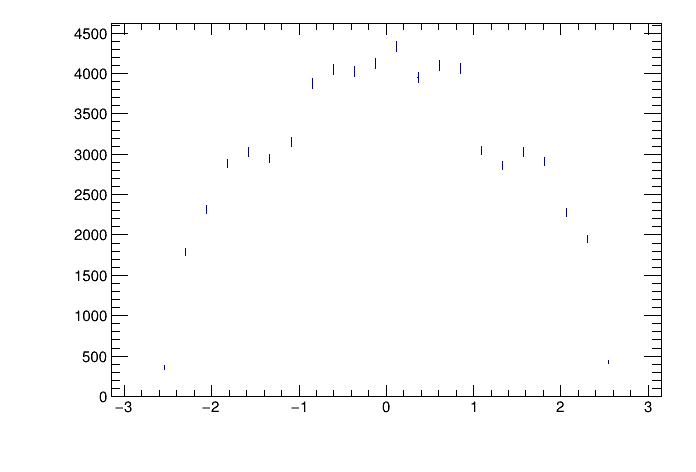

In [48]:
c = ROOT.TCanvas()
h = ROOT.TFile('/home/newhouse/public/Analysis/LRT/lrtanalysis/run/output/files_VH4b_V7.root')
sig = h.Get('TruthLinkedIsLRTIsSignalTechnical')
sig.ls()

track_eta = sig.Get("truth_eta")
track_eta.Draw()
c.Draw()

Name: truth_absd0 Title:  NbinsX: 75


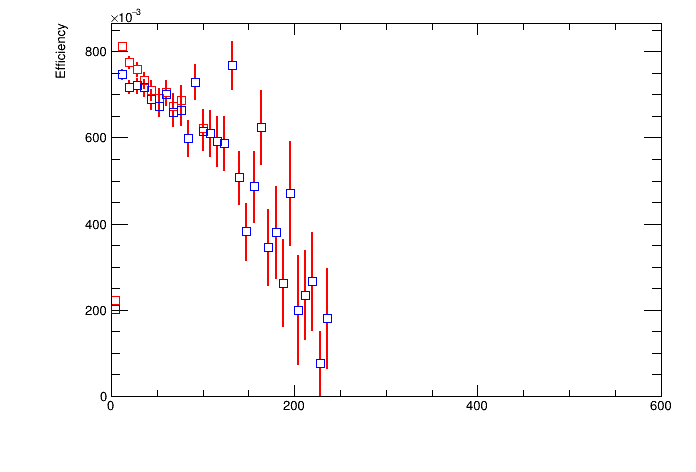

In [154]:
var = 'pt'
c = ROOT.TCanvas()
h = ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/plots/Efficiency_files_{sig}_V7.root')
h.Get("Efficiency").Get(f"truth_{var}").Draw("")
g = ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/plots/Efficiency_files_{sig}_V7nn.root')
hist = g.Get("Efficiency").Get(f"truth_{var}")
hist.SetMarkerColor(ROOT.kBlue)
hist.Draw("same")
print(hist)
c.Draw()

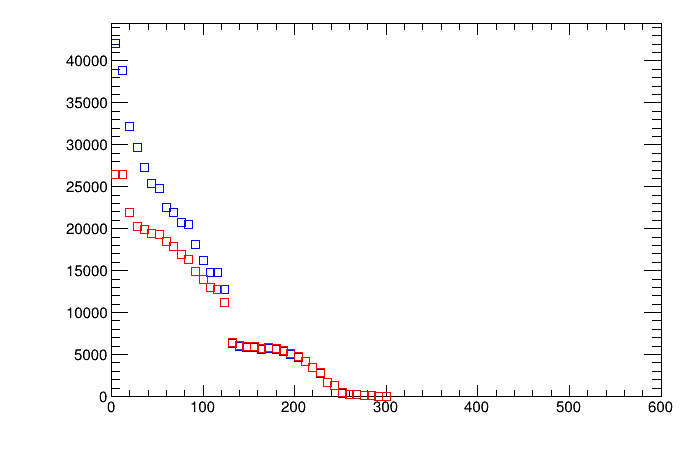

In [155]:
sig = 'HNL'
c = ROOT.TCanvas()
f = ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/output/files_{sig}_V7.root')
hist= f.Get("TrackIsFakeIsLRTPassSelection0").Get(f"track_{var}")
hist.SetMarkerColor(ROOT.kBlue)
hist.SetMarkerSize(1)
hist.SetMarkerStyle(25)
hist.Draw("SAME")
g = ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/output/files_{sig}_V7nn.root')
hist= g.Get("TrackIsFakeIsLRTPassSelection0").Get(f"track_{var}")
hist.SetMarkerColor(ROOT.kRed)
hist.SetMarkerSize(1)
hist.SetMarkerStyle(25)
hist.Draw("SAME")

c.Draw()